In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from statsmodels.tsa.stattools import adfuller, kpss

In [42]:
nordpool = pd.read_csv(r'C:\Users\Lenovo\Documents\MeusProjetos\Analise-Sincronia-SeriesTemporais-Soja\NP.csv', usecols=["Date", " Price"])
nordpool

,Date,Price
0,2013-01-01 00:00:00,31.05
1,2013-01-01 01:00:00,30.47
2,2013-01-01 02:00:00,28.92
3,2013-01-01 03:00:00,27.88
4,2013-01-01 04:00:00,26.96
...,...,...
52411,2018-12-24 19:00:00,50.72
52412,2018-12-24 20:00:00,49.86
52413,2018-12-24 21:00:00,49.09
52414,2018-12-24 22:00:00,49.02


In [43]:
nordpool['Date'] = pd.to_datetime(nordpool['Date'])
nordpool['Date'] = nordpool['Date'].dt.strftime("%d/%m/%Y")
nordpool['Date'] = pd.to_datetime(nordpool['Date'], format='mixed')
nordpool = nordpool.rename(columns={'Date':'DATA'})
nordpool = nordpool.set_index('DATA')

<Axes: xlabel='DATA'>

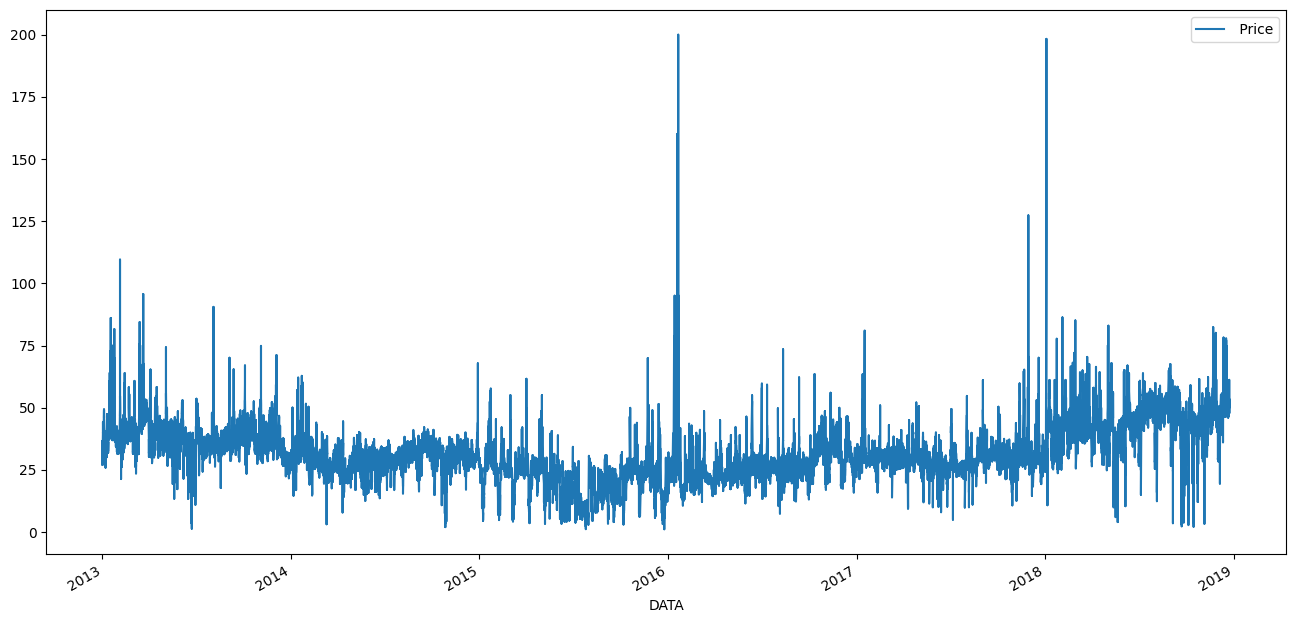

In [44]:
nordpool.plot(figsize=(16,8))

# Análise de estacionariedade

## Dickey-Fuller

In [45]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput[f"Critical Value ({key})"] = value
    print(dfoutput)


adf_test(nordpool) #série não estacionária se p-value > 0.05

Results of Dickey-Fuller Test:
Test Statistic                -6.986401e+00
p-value                        7.948180e-10
#Lags Used                     5.800000e+01
Number of Observations Used    5.235700e+04
Critical Value (1%)           -3.430475e+00
Critical Value (5%)           -2.861595e+00
Critical Value (10%)          -2.566799e+00
dtype: float64


## KPSS

In [46]:
def kpss_test(x, h0_type='c'):
  indices = ['Estatística do teste', 'valor-p', '# de Lags']
  kpss_test = kpss(x, regression=h0_type, nlags="legacy")
  results = pd.Series(kpss_test[0:3], index=indices)
  print('H0: A série temporal é estacionária (caso valor-p > 0.05)')
  for key, value in kpss_test[3].items():
    results[f'Critical Value ({key})'] = value
  
  return results

In [47]:
kpss_test(nordpool)  #série não estacionária, p-value < 0.05

H0: A série temporal é estacionária (caso valor-p > 0.05)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2852\699921468.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(x, regression=h0_type, nlags="legacy")


Estatística do teste     15.301313
valor-p                   0.010000
# de Lags                58.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Identificada estacionariedade por Dickey-Fuller, porém, KPSS indicou não estacionariedade. Isso pode indicar que, mesmo que os dados sejam não estacionários, já que há uma leve tendência de aumento perceptível, a série temporal talvez demonstre algum comportamento estacionário.

# Amplitude e fase

In [52]:
nordpool_fft = np.fft.fft(nordpool)
nordpool_ifft = np.fft.ifft(nordpool_fft) / np.size(nordpool[' Price'])

amp = np.abs(nordpool_ifft)

fase = np.arctan2(np.imag(nordpool_ifft), np.real(nordpool_ifft))

fase_acm = np.unwrap(fase)

In [58]:
nordpool['Amplitude'] = amp

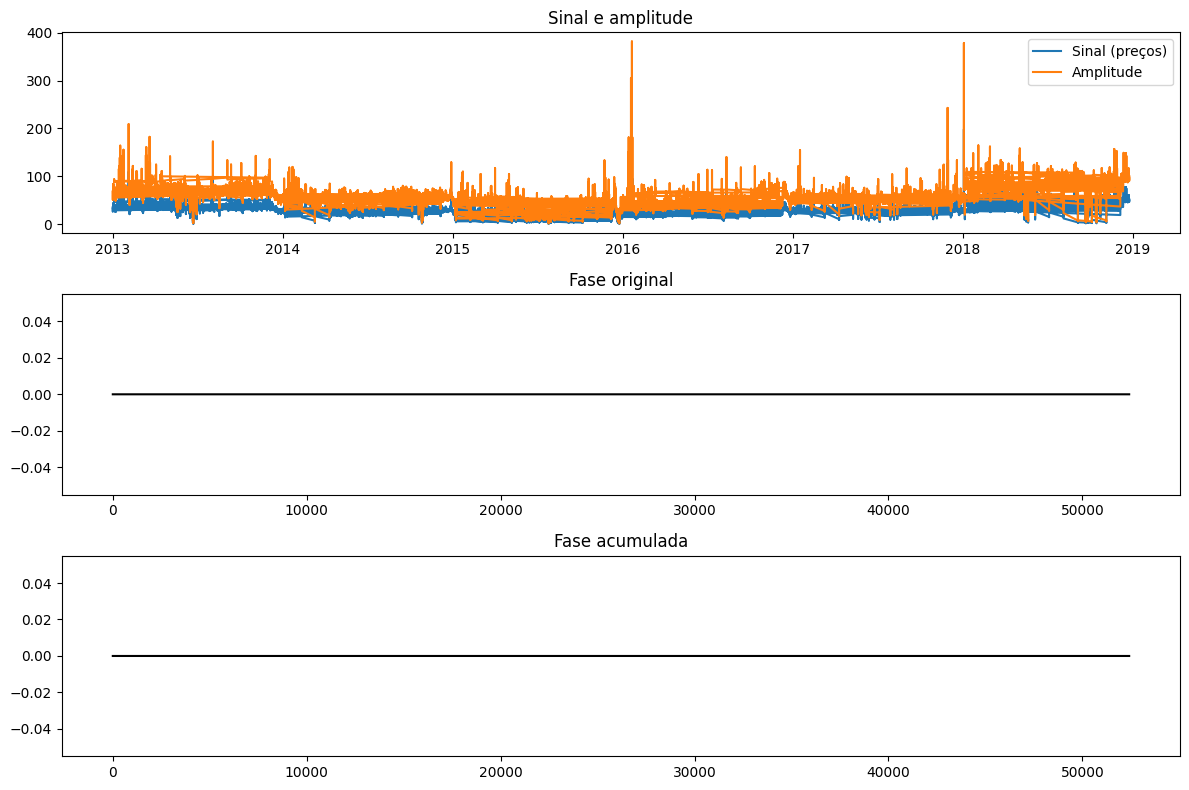

In [64]:
fig, ax = plt.subplots(3,1, figsize=(12,8))

ax[0].plot(nordpool[' Price'], label='Sinal (preços)')
ax[0].plot(100000*nordpool['Amplitude'], label='Amplitude')
ax[0].legend(loc='upper right')
ax[0].set_title('Sinal e amplitude')

ax[1].plot(fase, color='black')
ax[1].set_title('Fase original')

ax[2].plot(fase_acm, color='black')
ax[2].set_title('Fase acumulada')

plt.tight_layout()

In [62]:
nordpool

,Price,Amplitude
DATA,,
2013-01-01,31.05,0.000592
2013-01-01,30.47,0.000581
2013-01-01,28.92,0.000552
2013-01-01,27.88,0.000532
2013-01-01,26.96,0.000514
...,...,...
2018-12-24,50.72,0.000968
2018-12-24,49.86,0.000951
2018-12-24,49.09,0.000937


In [54]:
amp

array([[0.00059238],
       [0.00058131],
       [0.00055174],
       ...,
       [0.00093655],
       [0.00093521],
       [0.00091766]])